- https://scikit-learn.org/stable/modules/preprocessing.html#


# Pre-requisites

In [1]:
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Ingestion

In [3]:
rawData = fetch_california_housing()
print(type(rawData))
print(rawData.DESCR)

<class 'sklearn.utils._bunch.Bunch'>
.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1

In [4]:
dfHousing = pd.DataFrame(data=rawData.data, columns=rawData.feature_names)
dfHousing.sample(5)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
7467,3.0987,43.0,5.209354,1.084633,1732.0,3.857461,33.92,-118.19
3169,1.7716,29.0,4.131617,1.077253,2949.0,4.218884,35.24,-118.91
8429,4.1023,46.0,4.808594,0.902344,793.0,3.097656,33.92,-118.36
9779,1.7548,30.0,4.227920,1.179487,1200.0,3.418803,36.21,-121.13
4946,1.2446,27.0,4.147727,1.185606,1768.0,3.348485,34.02,-118.30


In [5]:
print(rawData.target_names)
dfHousing['MedHouseVal'] = pd.Series(rawData.target)
dfHousing.info()

['MedHouseVal']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


# Data preparation

In [6]:
# no missing values found
dfHousing.dropna().shape

(20640, 9)

## Outlier analysis

<Axes: >

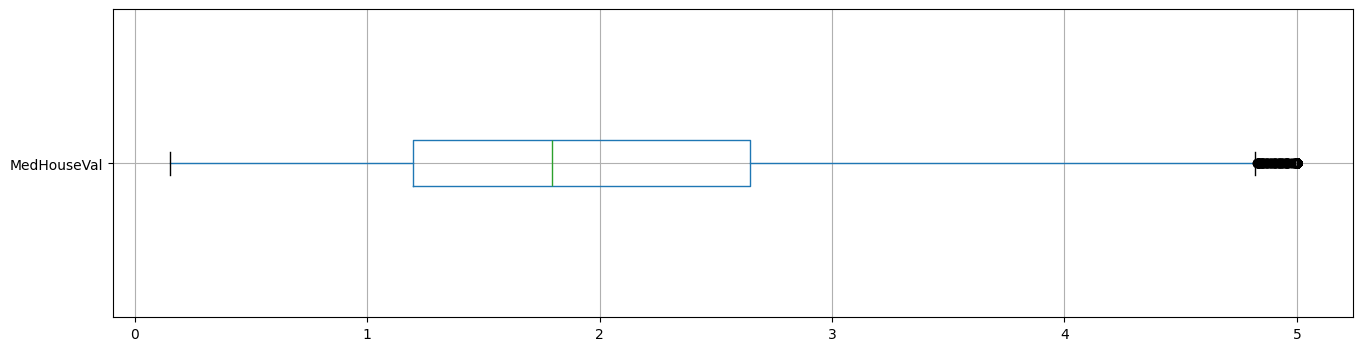

In [7]:
# box plot shows outliers at the top
dfHousing.boxplot(column='MedHouseVal', vert=False, figsize=(16,4))

In [8]:
dfHousing['MedHouseVal'].median()

np.float64(1.797)

In [9]:
dfHousing['MedHouseVal'].mean()

np.float64(2.068558169089147)

<Axes: ylabel='Frequency'>

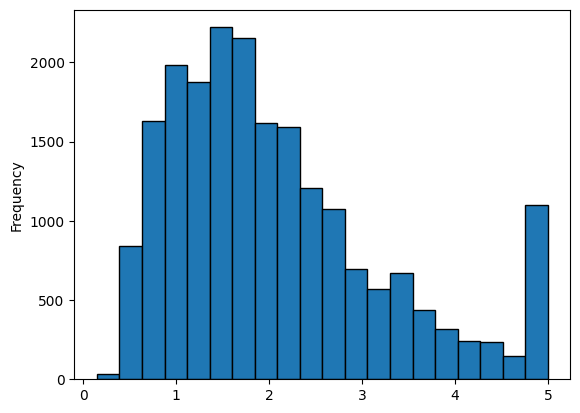

In [10]:
# histogram shows higher frequency of observations at the top-end
fig, ax = plt.subplots(1, 1)
dfHousing['MedHouseVal'].plot.hist(ax=ax, bins=20, edgecolor='black')

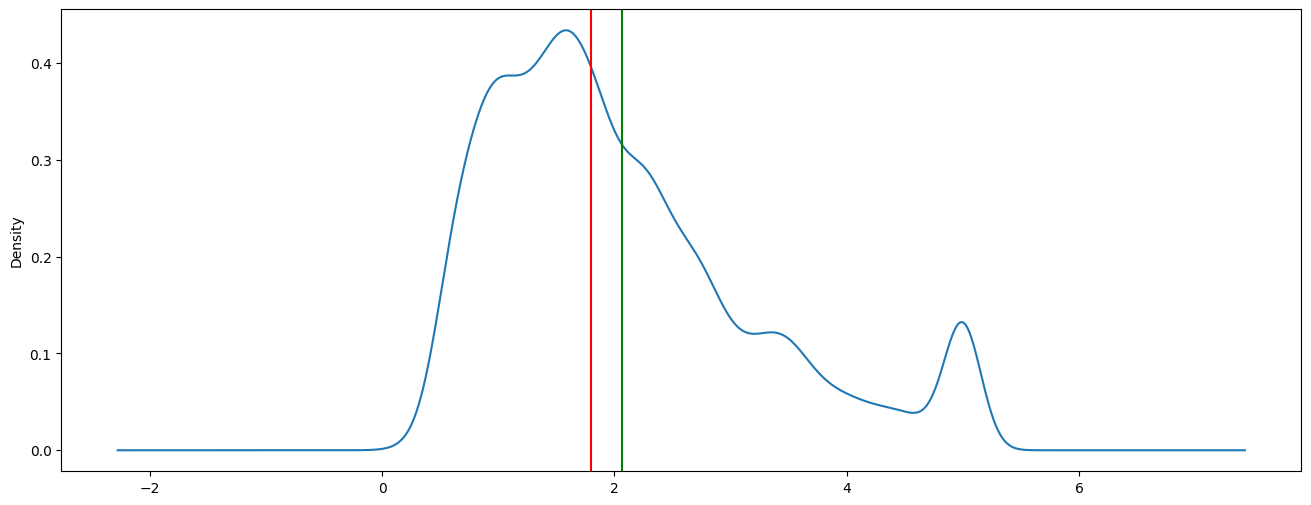

In [11]:
# probability density function shows a right-skewed distribution:
    # peak of the distribution is on the left side.
    # mean is greater than the median.
dfHousing['MedHouseVal'].plot.density(figsize=(16, 6))
plt.axvline(x=dfHousing['MedHouseVal'].median(),color='r', label='median')
plt.axvline(x=dfHousing['MedHouseVal'].mean(),color='g', label='mean')
plt.show()

In [12]:
print(dfHousing.MedHouseVal.max())
# counting the records which have the highest value
dfHousing.loc[dfHousing.MedHouseVal == dfHousing.MedHouseVal.max()].shape

5.00001


(965, 9)

## Outlier treatment(removal)

In [13]:
print(dfHousing.shape[0] - 965)
dfHousing = dfHousing.loc[dfHousing.MedHouseVal != 5.00001]
dfHousing.shape

19675


(19675, 9)

## One-hot encoding categorical values

In [14]:
# no string features to encode
dfHousing.dtypes

MedInc         float64
HouseAge       float64
AveRooms       float64
AveBedrms      float64
Population     float64
AveOccup       float64
Latitude       float64
Longitude      float64
MedHouseVal    float64
dtype: object

## Repurposing the regression dataset for classification usecase

In [15]:
medianOfMedHouseVal = dfHousing.MedHouseVal.median()
medianOfMedHouseVal

np.float64(1.738)

In [16]:
dfHousing['aboveMedian'] = (dfHousing.MedHouseVal > medianOfMedHouseVal)
dfHousing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19675 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       19675 non-null  float64
 1   HouseAge     19675 non-null  float64
 2   AveRooms     19675 non-null  float64
 3   AveBedrms    19675 non-null  float64
 4   Population   19675 non-null  float64
 5   AveOccup     19675 non-null  float64
 6   Latitude     19675 non-null  float64
 7   Longitude    19675 non-null  float64
 8   MedHouseVal  19675 non-null  float64
 9   aboveMedian  19675 non-null  bool   
dtypes: bool(1), float64(9)
memory usage: 1.5 MB


## Splitting the dependant variable from the dataset

In [17]:
dfX = dfHousing.drop(['MedHouseVal','aboveMedian'], axis=1)
print(dfX.columns)
dsY = dfHousing['aboveMedian']
print(dsY.name)

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')
aboveMedian


## Train, Test split

In [18]:
# 80-20 split
# shuffle the dataset to limit inadverdent patterns in training data
xTrain, xTest, yTrain, yTest = train_test_split(dfX, dsY, test_size=0.2, shuffle=True)
print(xTrain.shape, xTest.shape, yTrain.shape, yTest.shape)

(15740, 8) (3935, 8) (15740,) (3935,)


## Standardization

In [19]:
# Standardize features by removing the mean and scaling to unit variance 
# i.e., mean becomes 0, std dev becomes 1
# It is possible to disable either centering or scaling by either passing with_mean=False or with_std=False to the constructor
scaler = StandardScaler(with_mean=True, with_std=True).fit(xTrain)
type(scaler)


sklearn.preprocessing._data.StandardScaler

In [20]:
xTrainScaled = scaler.transform(xTrain)
xTestScaled = scaler.transform(xTest)

# Training

In [21]:
# liblinear solver works best for binary classification on small datasets 
modelLogistic = LogisticRegression(solver='liblinear').fit(xTrainScaled, yTrain)

In [22]:
# evaluating how the model performs on the training dataset
# accuracy score measures how many of the model's classification were correct on the training data
modelLogistic.score(xTrainScaled, yTrain)

0.8229987293519695

In [23]:
yPred = modelLogistic.predict(xTestScaled)
yPred.shape

(3935,)

In [24]:
dfCompare = pd.DataFrame({
    'predicted': yPred,
    'actual': yTest,
})
dfCompare.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3935 entries, 15682 to 7088
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   predicted  3935 non-null   bool 
 1   actual     3935 non-null   bool 
dtypes: bool(2)
memory usage: 38.4 KB


In [25]:
dfCompare.sample(10)

,predicted,actual
17033,True,True
7233,False,False
16749,True,True
7699,True,True
19080,False,True
10910,False,False
1997,False,False
4387,True,True
17024,True,True
8137,True,True


In [ ]:
# model's performance the test set is similar to the training set
accuracy_score(yTest, yPred)

0.827700127064803